# Open Library - Part 2

#### Reading the processed files in Part 1. Now we are going to work with the dataset gold_openlibrary_books_with_reviews_summary/ that contains all the books that got any reviews.

#### EDA - Reading files from S3 and analyzing the data

In [1]:
import requests
import json
import pandas as pd
import boto3    
from datetime import datetime
import configparser
from botocore.exceptions import ClientError
import os

parser = configparser.ConfigParser()
parser.read("file.config")
access_key = parser.get("aws_boto_credentials","access_key")
secret_key = parser.get("aws_boto_credentials","secret_access_key")
bucket_name = parser.get("aws_s3_services","s3_bucket_openlibrary")

s3_client = boto3.client('s3',
                  aws_access_key_id=access_key,
                  aws_secret_access_key=secret_key)


In [2]:
def read_parquet_files(bucket:str, key:str):
    '''
    returns a pandas df from a single parque file in the specified S3 location
    '''
    s3_loc = "s3://" + bucket + "/" +  key
    df = pd.read_parquet(s3_loc)
    return df

In [3]:
def read_works_dataset():
    '''
    reads the parquet files from S3 anre returns a dataframe.
    Calls the function read_parquet_files
    '''
    s3_keys = s3_client.list_objects(Bucket=bucket_name)["Contents"]
    s3_files = [x["Key"] for x in s3_keys]

    df = pd.DataFrame()
    try: 
        tbl = 'gold_openlibrary_works_with_reviews_summary'
        for file in s3_files:
            if file.split("/")[0] == tbl and file.split(".")[-1] == "parquet":
                df_tmp = read_parquet_files(bucket_name, file)
                df = pd.concat([df, df_tmp])
    except TypeError:
        print(f"{file} is not a parquet file")
    finally:
        print("All the files were loaded to the dataframe")
        
    return df

In [4]:
def load_df():
    path_to_file = 'data/works_with_reviews_summary.csv'
    if not os.path.isfile(path_to_file):
        df = read_works_dataset()
        df.to_csv(path_to_file)
    elif os.path.isfile(path_to_file):
        df = pd.read_csv(path_to_file)
    return df

In [5]:
# loads the data from S3 or the local file if exists
df = load_df()

In [6]:
display(df.shape)
display(df.head())

(268995, 11)

,Unnamed: 0,works_reference,review_year,review_month,rating_count,rating_avg,title,author_name,author_personal_name,subjects,description_text
0,0,/works/OL95897W,2021,10,1,3.0,Hammer of the Gods,Stephen Davis,Stephen Davis,['Biography' 'Led Zeppelin (Musical group)' 'R...,NaN
1,1,/works/OL95897W,2020,12,2,3.0,Hammer of the Gods,Stephen Davis,Stephen Davis,['Biography' 'Led Zeppelin (Musical group)' 'R...,NaN
2,2,/works/OL95896W,2022,9,1,1.0,Old Gods Almost Dead,Stephen Davis,Stephen Davis,['Biography & Autobiography' 'Music' 'Nonficti...,"The acclaimed, bestselling rock-and-roll biogr..."
3,3,/works/OL389633W,2021,10,1,4.0,Elements of the theory of elliptic and associa...,Mahadev Dutta,Mahadev Dutta,['Elliptic functions' 'Functions' 'Integral ca...,NaN
4,4,/works/OL389729W,2018,11,1,5.0,Neurologi klinis dasar,Mahar Mardjono,Mahar Mardjono,NaN,Basic clinical neurology; textbook.


#### Once the df is loaded, we can aggregate the data to get the most popular books, genres and some other insights

In [7]:
# Books with more reviews
df1 = pd.DataFrame(df.groupby(["works_reference","author_name","title"]).agg(rating_count=("rating_count","count"),
                                        rating_sum=("rating_avg","sum"))).reset_index()

df1["rating_average"] = (df1["rating_sum"] / df1["rating_count"]).round(2)

df1 = df1.drop(columns=["rating_sum"])

df1.sort_values(by="rating_count",ascending=False)

,works_reference,author_name,title,rating_count,rating_average
148364,/works/OL82563W,J. K. Rowling,Harry Potter and the Philosopher's Stone,55,4.30
95120,/works/OL262758W,J.R.R. Tolkien,The Hobbit,54,4.20
131277,/works/OL5720023W,Stephenie Meyer,Twilight,52,4.07
148326,/works/OL82536W,J. K. Rowling,Harry Potter and the Prisoner of Azkaban,51,4.34
147435,/works/OL81613W,Stephen King,It,50,4.05
...,...,...,...,...,...
62055,/works/OL1974614W,Patricia Ackert,Cause & Effect,1,5.00
62054,/works/OL19746146W,Chris Ferrie,Evolution for babies,1,5.00
62053,/works/OL1974613W,Patricia Ackert,Insights and ideas,1,2.00
62052,/works/OL19746123W,Dan Gutman,Mr. Will needs to chill!,1,4.00


In [34]:
# adding back the subjects and description to the aggregated data
cp_df = df[["title","subjects","description_text"]]
df2 = df1.merge(cp_df,on="title", how='left')
df2

,works_reference,author_name,title,rating_count,rating_average,subjects,description_text
0,/works/OL100001W,Margaret Maron,Death in blue folders,1,1.0,['Police' 'Fiction' 'Sigrid Harald (Fictitious...,NaN
1,/works/OL1000043W,Bill Crider,Muttketeer!,1,3.0,['Juvenile fiction' 'Adventure and adventurers...,Locked out of the school while Joe and his fri...
2,/works/OL100004W,Margaret Maron,Last lessons of summer,1,3.0,['Summer' 'Death' 'Family-owned business enter...,NaN
3,/works/OL100004W,Margaret Maron,Last lessons of summer,1,3.0,['Summer' 'Death' 'Family-owned business enter...,NaN
4,/works/OL1000059W,Elizabeth Boyle,Brazen Angel,1,3.0,['Social life and customs' 'Fiction' 'London (...,NaN
...,...,...,...,...,...,...,...
374437,/works/OL999982W,Dara Joy,Rejar,2,5.0,"['Fiction, romance, historical, general' 'Fict...",The Cat's Meow\r\n\r\nLord Byron thought he wa...
374438,/works/OL999982W,Dara Joy,Rejar,2,5.0,NaN,NaN
374439,/works/OL999982W,Dara Joy,Rejar,2,5.0,NaN,NaN
374440,/works/OL999983W,Dara Joy,Ritual of proof,1,5.0,['Feminism' 'Fiction' 'Large type books' 'Fict...,"In a world where women hold all the power, a t..."


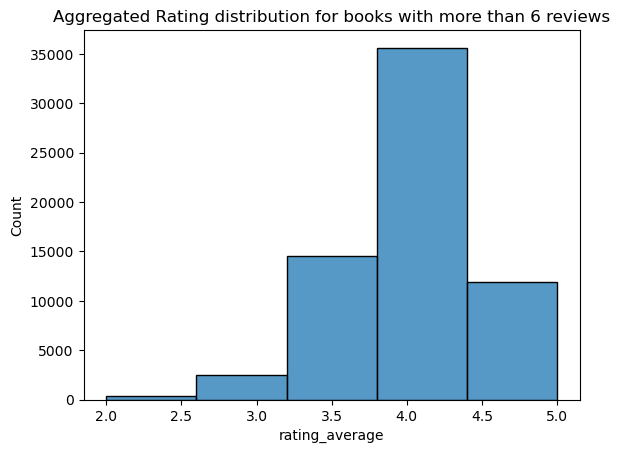

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df2[df2['rating_count'] >= 6], x="rating_average", bins=5)
plt.title("Aggregated Rating distribution for books with more than 6 reviews")
plt.show()

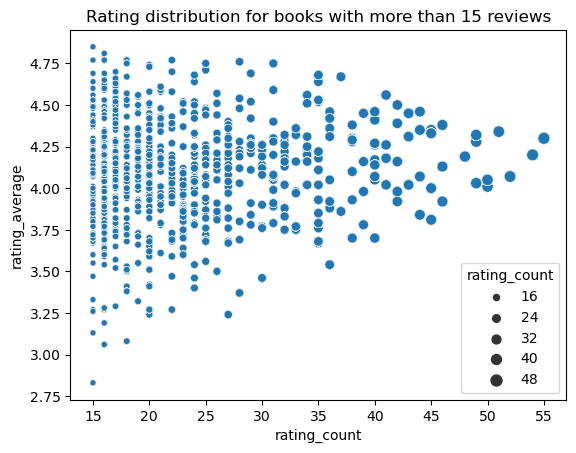

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df2[df2['rating_count'] >= 15], x="rating_count", y="rating_average", size="rating_count")
plt.title("Rating distribution for books with more than 15 reviews")
plt.show()

# when the number of reviews increases, it tends to converge in the 4.25
# Books with a rating of 5 usually have a low number of reviews. 
# Same thing happens with books with very low ratings

#### Extracting data from the API

In [16]:
import requests
import json

bs_response = requests.get("https://openlibrary.org/works/OL18020194W/bookshelves.json")
bs_response.json()

{'counts': {'want_to_read': 28089,
  'currently_reading': 1424,
  'already_read': 934}}

In [17]:
import requests
import json

res = requests.get("https://openlibrary.org/works/OL95897W/ratings.json")
res.json()

{'summary': {'average': 3.0, 'count': 3, 'sortable': 2.326390320734626},
 'counts': {'1': 0, '2': 1, '3': 1, '4': 1, '5': 0}}

In [18]:
def get_works_details(work_ref):
    """
    Returns the details about the work
    """
    
    try:
        
        bs_response = requests.get(f"https://openlibrary.org{work_ref}/bookshelves.json").json()
        bs_want_to_read = bs_response.get("counts").get("want_to_read")
        bs_currently_reading = bs_response.get("counts").get("currently_reading")
        bs_already_read = bs_response.get("counts").get("already_read")

        rt_response = requests.get(f"https://openlibrary.org{work_ref}/ratings.json").json()
        rating_average = rt_response.get("summary").get('average')
        rating_count = rt_response.get("summary").get('count')
        rating_1 = rt_response.get("counts").get('1')
        rating_2 = rt_response.get("counts").get('2')
        rating_3 = rt_response.get("counts").get('3')
        rating_4 = rt_response.get("counts").get('4')
        rating_5 = rt_response.get("counts").get('5')

        d = {'work_reference': [work_ref],
            'bs_want_to_read': [bs_want_to_read],
            'bs_currently_reading':[bs_currently_reading],
            'bs_already_read':[bs_already_read],
            'rating_average':[rating_average],
            'rating_count':[rating_count],
            'rating_1':[rating_1],
            'rating_2':[rating_2],
            'rating_3':[rating_3],
            'rating_4':[rating_4],
            'rating_5':[rating_5]}
        df_tmp = pd.DataFrame(data=d)
    
    except Exception as e:
        print(f"Exception occurred when processing {work_ref}", e)
    
    return df_tmp

In [19]:
def extract_ol_api(df, file_name):
    """
    Returns work details from the API call as dataframe
    """
    import requests
    import json
    import os
    import time
    
    if not os.path.isfile(f'data/{file_name}'):
        
        df_api = pd.DataFrame()
        try:
            
            for work in df:
                df_tmp = get_works_details(work)
                df_api = pd.concat([df_tmp,df_api], ignore_index=True)
                time.sleep(0.25)
        except Exception as e:
            print(f"Exception occurred when processing {work}", e)
        
        finally:
            print("API call process finished!")
            display(df_api.head())
            
        df_api.to_csv(f'data/{file_name}', index=False)
            
    return df_api

### Preparing the dataset with the 1000 most reviewed books for using them in a dashboard

In [40]:
dataset_1000books = df1.sort_values(by="rating_count",ascending=False).nlargest(1000, columns=["rating_count"])
dataset_1000books.head()

,works_reference,author_name,title,rating_count,rating_average
148364,/works/OL82563W,J. K. Rowling,Harry Potter and the Philosopher's Stone,55,4.30
95120,/works/OL262758W,J.R.R. Tolkien,The Hobbit,54,4.20
131277,/works/OL5720023W,Stephenie Meyer,Twilight,52,4.07
148326,/works/OL82536W,J. K. Rowling,Harry Potter and the Prisoner of Azkaban,51,4.34
147435,/works/OL81613W,Stephen King,It,50,4.05


In [55]:
# once we have the list of 1000 books, we'll use the functions prepared for extracting the details from the API
import os

# to ensure we don't call the API more than necessary, we can double check we have unique references
df_ids_to_extract = dataset_1000books['works_reference'].unique()
file_name = 'dataset_books_api.csv'

#download if file doesn't exist
if not os.path.isfile(f'data/{file_name}'):
    dataset_books_api = extract_ol_api(df_ids_to_extract, file_name)

# Read file if exists
elif os.path.isfile(f'data/{file_name}'):
    dataset_books_api = pd.read_csv(f'data/{file_name}')

print("Number of records extracted from API:",len(dataset_1000books_marketing.index))
print("File content loaded to DataFrame")

Number of records extracted from API: 1000
File content loaded to DataFrame


In [72]:
dataset_books_api

,work_reference,bs_want_to_read,bs_currently_reading,bs_already_read,rating_average,rating_count,rating_1,rating_2,rating_3,rating_4,rating_5
0,/works/OL3759085W,43,1,40,4.250000,16,1,0,1,6,8
1,/works/OL261196W,53,4,44,4.000000,22,0,1,7,5,9
2,/works/OL262460W,288,14,45,4.043478,23,0,0,8,6,9
3,/works/OL453743W,45,2,38,4.388889,18,0,0,2,7,9
4,/works/OL17043626W,180,5,32,3.750000,24,1,2,6,8,7
...,...,...,...,...,...,...,...,...,...,...,...
995,/works/OL81613W,5424,337,406,4.150685,365,24,9,51,85,196
996,/works/OL82536W,2106,144,640,4.304786,397,12,5,53,107,220
997,/works/OL5720023W,2412,173,369,3.666667,264,41,27,36,35,125
998,/works/OL262758W,2036,159,516,4.266854,356,12,15,29,110,190


In [73]:
dataset_1000books_marketing = dataset_1000books.merge(dataset_books_api, left_on='works_reference', right_on='work_reference',
                        how='left',suffixes=('_cal','_api'))

#drop columns we no longer need for the final dataset
dataset_1000books_marketing = dataset_1000books_marketing.drop(columns=["rating_count_cal","rating_average_cal","work_reference"])

subjects = df[["works_reference","subjects","description_text"]]
subjects = subjects.drop_duplicates(subset=['works_reference'])

dataset_1000books_marketing = dataset_1000books_marketing.merge(subjects, how="left", on='works_reference')
#renaming some columns
dataset_1000books_marketing = dataset_1000books_marketing.rename(columns={"bs_want_to_read":"want_to_read",
                                                              "bs_currently_reading":"currently_reading",
                                                              "bs_already_read":"already_read",
                                                              "rating_average_api":"rating_average",
                                                              "rating_count_api":"rating_count"})

print("number of records in dataset:",len(dataset_1000books_marketing.index))

dataset_1000books_marketing.head()

number of records in dataset: 1000


,works_reference,author_name,title,want_to_read,currently_reading,already_read,rating_average,rating_count,rating_1,rating_2,rating_3,rating_4,rating_5,subjects,description_text
0,/works/OL82563W,J. K. Rowling,Harry Potter and the Philosopher's Stone,9272,833,835,4.288256,562,42,15,47,93,365,['Ghosts' 'Monsters' 'Vampires' 'Witches'\n 'C...,NaN
1,/works/OL262758W,J.R.R. Tolkien,The Hobbit,2036,159,516,4.266854,356,12,15,29,110,190,['Arkenstone' 'Battle of Five Armies' 'invisib...,NaN
2,/works/OL5720023W,Stephenie Meyer,Twilight,2412,173,369,3.666667,264,41,27,36,35,125,['New York Times bestseller' 'nyt:series_books...,NaN
3,/works/OL82536W,J. K. Rowling,Harry Potter and the Prisoner of Azkaban,2106,144,640,4.304786,397,12,5,53,107,220,['Fantasy fiction' 'orphans' 'foster homes' 'f...,"Harry Potter #3\r\n\r\nFor Harry Potter, it’s ..."
4,/works/OL81613W,Stephen King,It,5424,337,406,4.150685,365,24,9,51,85,196,['coming of age' 'thrillers' 'suspense' 'horro...,NaN


In [74]:
dataset_1000books_marketing["rating_average"].mean()

4.056166266111403

In [75]:
# we will include an indicator that could help to identify books that have a higher rate of 5s using an NPS formula

dataset_1000books_marketing["NPS"] = ( (dataset_1000books_marketing["rating_5"] - (dataset_1000books_marketing["rating_1"]
                                                                               + dataset_1000books_marketing["rating_2"]
                                                                               + dataset_1000books_marketing["rating_3"]))
                                      / dataset_1000books_marketing["rating_count"]
                                     )

In [77]:
# 10 books with the highest NPS
dataset_1000books_marketing.nlargest(n=10, columns='NPS')
# Calculte rankings for the requested metrics 
dataset_1000books_marketing["NPS_rank"] = dataset_1000books_marketing["NPS"].rank(ascending=False)

In [79]:
# 10 books with the highest general_ranking
dataset_1000books_marketing.nlargest(n=10, columns='NPS')

#now it is possible to see not only the most reviewed, but also compare it with their rate of 5s (NPS)

,works_reference,author_name,title,want_to_read,currently_reading,already_read,rating_average,rating_count,rating_1,rating_2,rating_3,rating_4,rating_5,subjects,description_text,NPS,NPS_rank
856,/works/OL18289083W,William Lawrence Faith,"Faith, Keyes, and Clark's Industrial chemicals",117,10,16,4.882353,17,0,0,1,0,16,"['Chemical industry' 'Chemistry, technical']",NaN,0.882353,1.0
789,/works/OL17606586W,Thea Stilton,Thea Stilton and the Lost Letters,141,6,48,4.761905,21,1,0,0,1,19,['Mystery and detective stories' 'Stealing' 'S...,The Thea Sisters are in Russia and they find a...,0.857143,2.0
296,/works/OL66946W,Dave Pelzer,"A child called ""it""",531,30,60,4.756757,37,1,1,0,2,33,['Biography' 'Abused children' 'Foster home ca...,This book chronicles the unforgettable account...,0.837838,3.0
595,/works/OL16361049W,Shannon Messenger,Keeper of the Lost Cities,331,24,48,4.777778,36,1,0,1,2,32,['Ability' 'Fiction' 'Fantasy' 'Psychic abilit...,NaN,0.833333,4.0
634,/works/OL8842598W,Kazu Kibuishi,Amulet,144,12,31,4.700000,20,1,0,1,0,18,['Haunted House' 'Supernatural' 'Amulet' 'Grap...,NaN,0.800000,5.0
747,/works/OL20882185W,Rachel Renée Russell,Dork Diaries 15,206,13,10,4.684211,19,1,0,1,0,17,['girls' 'friens' 'pls give back'],so excited to read it. pls hand in **yaaaaaaaa...,0.789474,6.0
992,/works/OL17628996W,Chris Colfer,The Land of Stories,91,4,12,4.785714,14,0,0,1,1,12,['Fairy tales' 'Characters in literature' 'Mag...,Alex and Conner Bailey have not been back to t...,0.785714,7.0
604,/works/OL5805254W,P. C. Cast,Marked,163,10,34,4.695652,23,1,0,0,3,19,['nyt:series_books=2009-05-30' 'Zoey Redbird (...,NaN,0.782609,8.0
381,/works/OL17054790W,Rick Riordan,Percy Jackson's Greek Gods,614,46,57,4.701754,57,2,0,3,3,49,['Greek Gods' 'Young adult fiction' 'Percy Jac...,NaN,0.771930,9.0
207,/works/OL17793648W,Scott Cawthon,The Silver Eyes (Five Nights At Freddy's #1),502,27,33,4.627907,43,3,0,2,0,38,['Horror' 'psychology' 'murder' 'animatronics'...,NaN,0.767442,10.0


In [81]:
dataset_1000books_marketing.head(10)
#as we can see, the books with most reviews are not necessarily the most loved.

,works_reference,author_name,title,want_to_read,currently_reading,already_read,rating_average,rating_count,rating_1,rating_2,rating_3,rating_4,rating_5,subjects,description_text,NPS,NPS_rank
0,/works/OL82563W,J. K. Rowling,Harry Potter and the Philosopher's Stone,9272,833,835,4.288256,562,42,15,47,93,365,['Ghosts' 'Monsters' 'Vampires' 'Witches'\n 'C...,NaN,0.464413,137.0
1,/works/OL262758W,J.R.R. Tolkien,The Hobbit,2036,159,516,4.266854,356,12,15,29,110,190,['Arkenstone' 'Battle of Five Armies' 'invisib...,NaN,0.376404,226.0
2,/works/OL5720023W,Stephenie Meyer,Twilight,2412,173,369,3.666667,264,41,27,36,35,125,['New York Times bestseller' 'nyt:series_books...,NaN,0.079545,643.0
3,/works/OL82536W,J. K. Rowling,Harry Potter and the Prisoner of Azkaban,2106,144,640,4.304786,397,12,5,53,107,220,['Fantasy fiction' 'orphans' 'foster homes' 'f...,"Harry Potter #3\r\n\r\nFor Harry Potter, it’s ...",0.377834,223.0
4,/works/OL81613W,Stephen King,It,5424,337,406,4.150685,365,24,9,51,85,196,['coming of age' 'thrillers' 'suspense' 'horro...,NaN,0.306849,302.0
5,/works/OL45790W,Roald Dahl,Charlie and the Chocolate Factory,1425,113,252,4.005291,189,14,8,30,48,89,"['Childrens Media Tie-In Books'\n ""Children's ...",NaN,0.195767,447.0
6,/works/OL8483260W,Jeff Kinney,Diary of a Wimpy Kid,2609,202,282,4.208889,225,16,8,26,38,137,['School stories' 'Families' 'Diaries' 'Middle...,NaN,0.386667,212.0
7,/works/OL103123W,Ray Bradbury,Fahrenheit 451,1885,101,442,3.976821,302,8,17,65,96,116,['Mechanical Hound' 'girl next door' 'Long Now...,Fahrenheit 451 is a 1953 dystopian novel by Am...,0.086093,635.0
8,/works/OL14933414W,J.R.R. Tolkien,The Fellowship of the Ring,902,63,363,4.344444,270,3,6,30,87,144,['Elves' 'Dwarves' 'evil' 'fear' 'friends' 'ho...,"One Ring to rule them all, One Ring to find th...",0.388889,207.5
9,/works/OL527464W,Napoleon Hill,Think and grow rich,5600,477,200,4.128000,250,23,10,26,44,147,['Business' 'Exito en los negocios' 'Finance' ...,THE WORKBOOK UNLOCKS THE SECRETS HIDDEN BETWEE...,0.352000,256.0


In [82]:
#saving the data to a csv and uploading to S3
dataset_1000books_marketing.to_csv("data/dataset_1000books_marketing.csv", index=False)

folder = '1000books_dataset'
file_name = 'dataset_1000books_marketing.csv'

try:
    s3_client.put_object(Bucket=bucket_name, Key=f'{folder}/')
    print(f'S3 folder {folder} created successfully')
except ClientError as e:
    print(e)
    
local_path = 'data/'+ file_name
s3_path_raw = f's3:/{bucket_name}'
key_raw = f"{folder}/{file_name}"
s3_path = f"{s3_path_raw}/{key_raw}"
print(f"S3 Path: {s3_path}")

try:
    s3_client.upload_file(local_path, bucket_name, key_raw)
except ClientError as e:
    print(e)

S3 folder 1000books_dataset created successfully
S3 Path: s3:/mcidaen3.open-library-ji34g0es9bj/1000books_dataset/dataset_1000books_marketing.csv
